In [1]:

%load_ext autoreload
%autoreload 2

In [2]:

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import gym
from gym import spaces
from Data.data_retrieval import get_data
from Utils.add_features import add_fisher
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import os
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback

In [3]:

class StockTradingEnv(gym.Env):

    def __init__(self, df, features, init_account_balance, window_shape):
        # initialize environment
        super(StockTradingEnv, self).__init__()
        # raw dataset
        self.df = df
        # how much $ do we have?
        self.init_account_balance = init_account_balance
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.window_shape = window_shape
        self.action_space = spaces.Discrete(2)
        self.current_step = self.window_shape-1
        self.signal_features = features
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(self.window_shape, self.signal_features.shape[-1]), dtype=np.float16)

        # share costs
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = self.init_account_balance
        self.net_worth = self.init_account_balance
        self.current_step = self.window_shape-1
        self.in_position = False
        self.position_value = 0.0
        self.price_bought = 0.0
        self.bet_bought = 0.0
        return self.get_observation()

    def get_observation(self):
        market_state = self.signal_features.iloc[self.current_step - self.window_shape+1:self.current_step+1]
        # print(f"Market state: {market_state}")
        return market_state

    def step(self, action):
        done = False
        if self.current_step==(len(self.df)):
            self.current_step=self.window_shape-1
            done=True
        self.take_action(action)
        reward = self.net_worth
        obs = self.get_observation()
        # print(done)
        self.current_step += 1
        return obs, reward, done, {}

    def take_action(self, action):

        # Set the current price to a random price within the time step
        current_price = self.df.iloc[self.current_step]["Close"]
        self.current_price = current_price
        self.datetime = self.df.index[self.current_step]


        # print("*"*100)
        # print(f"Current step: {self.current_step}")
        # print(f"df.iloc[self.current_step]: {df.iloc[self.current_step]}")
        # print(f"Datetime: {self.datetime}")


        if not self.in_position:
            if action == 1:  # OPEN LONG
                self.in_position = True
                self.price_bought = current_price
                self.bet_bought = self.balance
                self.balance -= self.bet_bought
                self.position_value = self.bet_bought
            else:  # KEEP LOOKING
                pass
        else:
            market_return = ((current_price - self.price_bought) / self.price_bought)
            if action == 1:  # HOLD LONG
                self.position_value = self.bet_bought * (1.0 + market_return)
            else:  # CLOSE LONG
                self.balance += self.bet_bought * (1.0 + market_return)
                self.in_position = False
                self.price_bought = 0.0
                self.bet_bought = 0.0
                self.position_value = 0.0

        self.net_worth = self.balance + self.position_value

    def render(self, mode='human'):
        return {
            'step': self.current_step,
            'price': self.current_price,
            'balance': self.balance,
            'position': self.position_value,
            'net_worth': self.net_worth,
            'profit': self.net_worth - self.init_account_balance,
            'datetime': self.datetime
        }

def evaluate_agent(env, df, model):
    obs = env.reset()
    history = {
        'balance': [],
        'action': [],
        'position': [],
        'net_worth': [],
        'price': [],
        'Datetime': []
    }

    for i in range(len(df) - HISTORICAL_STATES+1):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        state = env.render()
        history['action'].append(action[0])
        history['balance'].append(state['balance'])
        history['net_worth'].append(state['net_worth'])
        history['position'].append(state['position'])
        history['price'].append(state['price'])
        history['Datetime'].append(state['datetime'])
        if done[0] == True:
            break

    actions_over_time = pd.DataFrame({"Datetime": history['Datetime'], "action": history['action']}).set_index(("Datetime"))
    return history, actions_over_time



In [4]:
TICKER = ".NSEI"
INIT_NET_WORTH = 10000
HISTORICAL_STATES = 5
features = [
    {"feature": "Fisher5", "lookback": 5},
    {"feature": "Fisher20", "lookback": 20},
    # {"feature": "Fisher50", "lookback": 50},
    # {"feature": "Fisher100", "lookback": 100},
    # {"feature": "Fisher150", "lookback": 150},
    # {"feature": "Fisher300", "lookback": 300},
]
LR = 0.001
RANDOM_SEED = 11111
WINDOW = max([feature["lookback"] for feature in features])
train_percent = 0.8

df = get_data(TICKER, 'D').set_index('Datetime')

In [5]:
signal_features = pd.DataFrame(index=df.index)
for feature, lookback in [(feature["feature"], feature["lookback"]) for feature in features]:
    if feature == "Close":
        signal_features[feature] = df["Close"]
    if feature.startswith("Fisher"):
        signal_features[feature] = add_fisher([df, lookback])[f"Fisher{lookback}"]

train_df = df.iloc[:int(train_percent * len(df))]
test_df = df.iloc[int(train_percent * len(df)):]
train_signal_features = signal_features.iloc[:int(train_percent * len(signal_features))]
test_signal_features = signal_features.iloc[int(train_percent * len(signal_features)):]
NUM_EPISODES = 10
N_TIME_STEPS = NUM_EPISODES*(len(train_df) - HISTORICAL_STATES + 1)

In [6]:
# The algorithms require a vectorized environment to run
env_train = DummyVecEnv(
    [lambda: StockTradingEnv(train_df, train_signal_features, INIT_NET_WORTH, HISTORICAL_STATES)])
model = A2C('MlpPolicy', env_train, verbose=1, learning_rate=LR, seed=RANDOM_SEED)
model.learn(total_timesteps=N_TIME_STEPS, log_interval=(len(train_df) - HISTORICAL_STATES + 1))

Using cpu device


[]

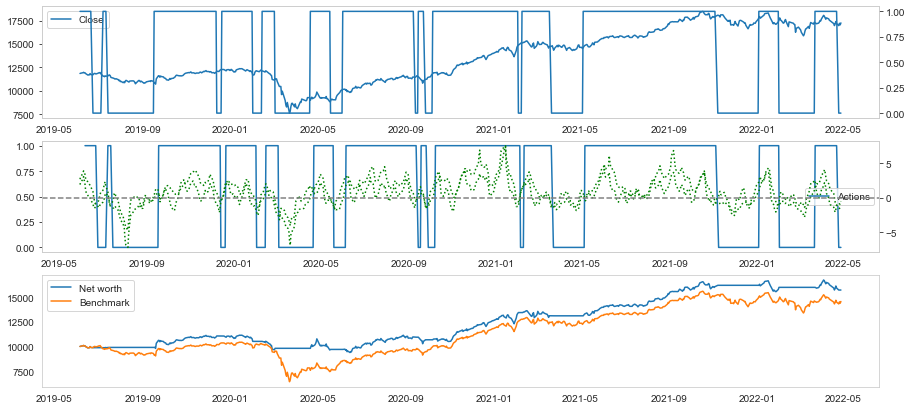

In [7]:
env_test = DummyVecEnv(
    [lambda: StockTradingEnv(test_df, test_signal_features, INIT_NET_WORTH, HISTORICAL_STATES)])
history_test, actions_over_time_test = evaluate_agent(env_test, test_df, model)
history_test = pd.DataFrame(history_test).set_index("Datetime")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))
ax1.plot(history_test['price'], label='Close')
ax1_copy = ax1.twinx()
ax1_copy.plot(actions_over_time_test, label='Actions')
ax2.plot(actions_over_time_test, label='Actions')
ax2_copy = ax2.twinx()
for feature in [feature["feature"] for feature in features]:
    ax2_copy.plot(test_signal_features[feature], label=feature, color='green', ls='dotted')
ax2_copy.axhline(0.0, ls='--', color='grey')
ax3.plot(history_test['net_worth'], label='Net worth')
ax3.plot(history_test['price'] * INIT_NET_WORTH / history_test['price'].iloc[0], label='Benchmark')
ax1.legend()
ax2.legend()
ax3.legend()
plt.plot()
